## Import necessary packages

In [1]:
import statsmodels.api as sm
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("poster")
sns.set(rc={"figure.figsize": (16, 9.)})
sns.set_style("whitegrid")

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

from icl_lens_sizing.preprocessing.preprocessing import prepare_training_data

## Load and prepare ICL data

In [2]:
path = "/Users/sortmanns/git/work/icl-lens-sizing/data/icl_data_2023-07-09.csv"
df = pd.read_csv(path, sep=";", decimal=',')

# Initiale Untersuchung der Features
Wir beginnen mit der vollen Feature-Menge, teilen die Daten in Einfluss- und Zielvariablen und berechnen ein paar
selbst gemachte Features (Feature Engineering).

In [8]:
# Feature Auswahl
features = ['implantat_size', 'alter', 'ACD', 'ACA_nasal', 'ACA_temporal', 'AtA', 'ACW',
            'ARtAR_LR', 'StS', 'StS_LR', 'CBID', 'CBID_LR', 'mPupil', 'WtW_MS-39', 'Sphaere', 'Zylinder']

# Feature Engineering
cbid_ratio = (lambda row: row['CBID'] / row['CBID_LR'])
ac_ratio = (lambda row: row['ACW'] / row['ACD'])
sts_ratio = (lambda row: row['StS'] / row['StS_LR'])
ata_ratio = (lambda row: row['AtA'] / row['ARtAR_LR'])
spherical_equivalent = (lambda row: row['Sphaere']-0.5*row['Zylinder'])
custom_features = {'spherical_equivalent': spherical_equivalent, 'cbid_ratio': cbid_ratio,
                   'ac_ratio':ac_ratio, 'sts_ratio':sts_ratio, 'ata_ratio':ata_ratio}

# Präparieren der Datensätze zur Weiterverarbeitung
feature_df, target_df, feature_mapping = prepare_training_data(df=df, target="Lens-ICPL-Distance", features=features,
                                                               custom_features=custom_features)

full_df = pd.concat([feature_df,target_df], axis=1)

### Berechnen der (Pearson-)Korrelationsmatrix und Visualisierung der Heatmap
Die Pearson Korrelation gibt uns Hinweise auf einen linearen(!) Zusammenhang zwischen Variablen. Eine hohe Korrelation mit der Zielvariablen ist wünschenswert. Eine hohe Korrelation zwischen den einzelnen Features hingegen ist nicht erwünscht.

Wir standardisieren die Features und beginnen dann mit dem Berechnen der (Pearson-)Korrelationsmatrix und der
Visualisierung der Heatmap. Das Standartisieren der Features hilft die Einflüsse der einzelnen Features besser zu verstehen.

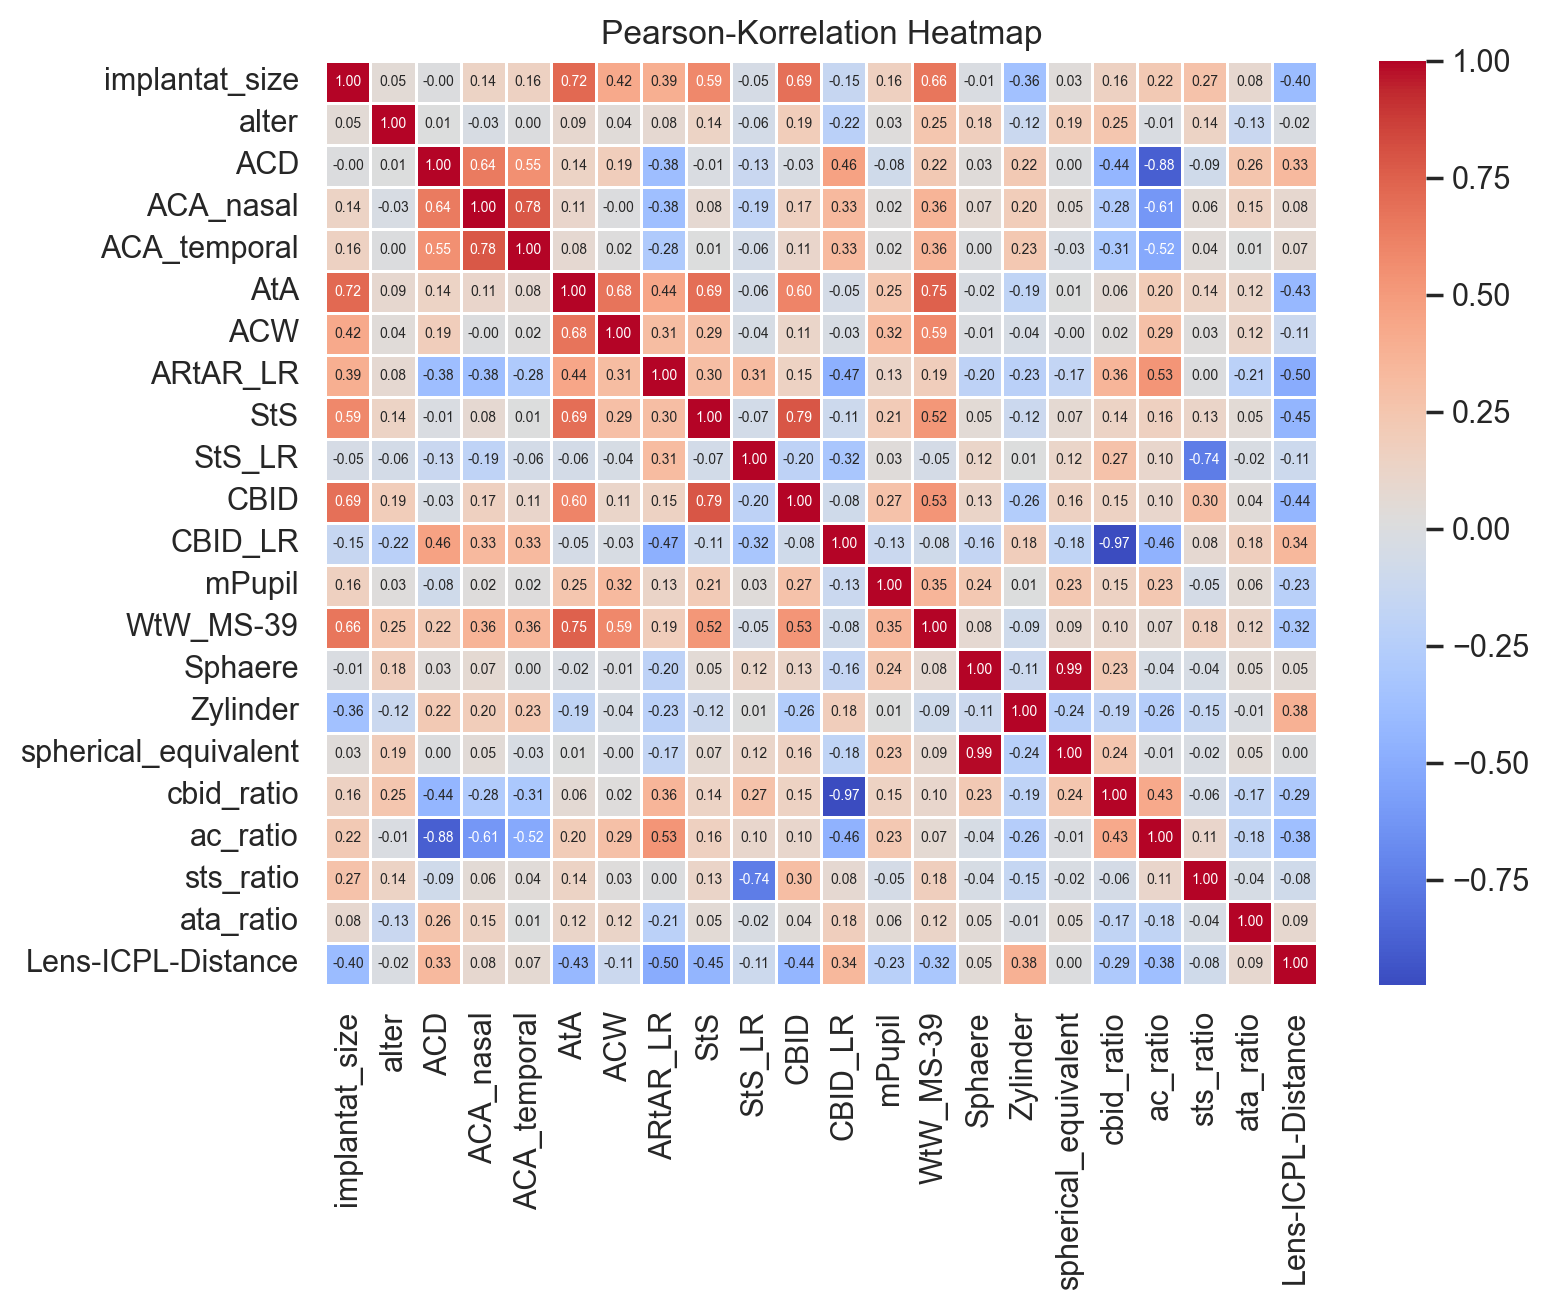

In [ ]:
# Store column names
column_names = full_df.columns.tolist()

# Create a StandardScaler object
scaler = StandardScaler()

# Fit and transform the DataFrame using the scaler
scaled_data = scaler.fit_transform(full_df)

# Convert the scaled data back to a DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=column_names)

scaled_corr_matrix = scaled_df.corr()

# Heatmap erstellen
plt.figure(figsize=(8, 6))
sns.heatmap(scaled_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, annot_kws={"size": 5})
plt.title('Pearson-Korrelation Heatmap')
plt.show()

### Untersuchung der Varianz der Features
Die Varianz eines Features kann uns Hinweise auf die Aussagekraft für das spätere Modell geben. Initial ist es
üblich Features mit hoher Varianz zu wählen. Um die Varianzen besser Vergleichen zu können normieren wir die Features vorher.

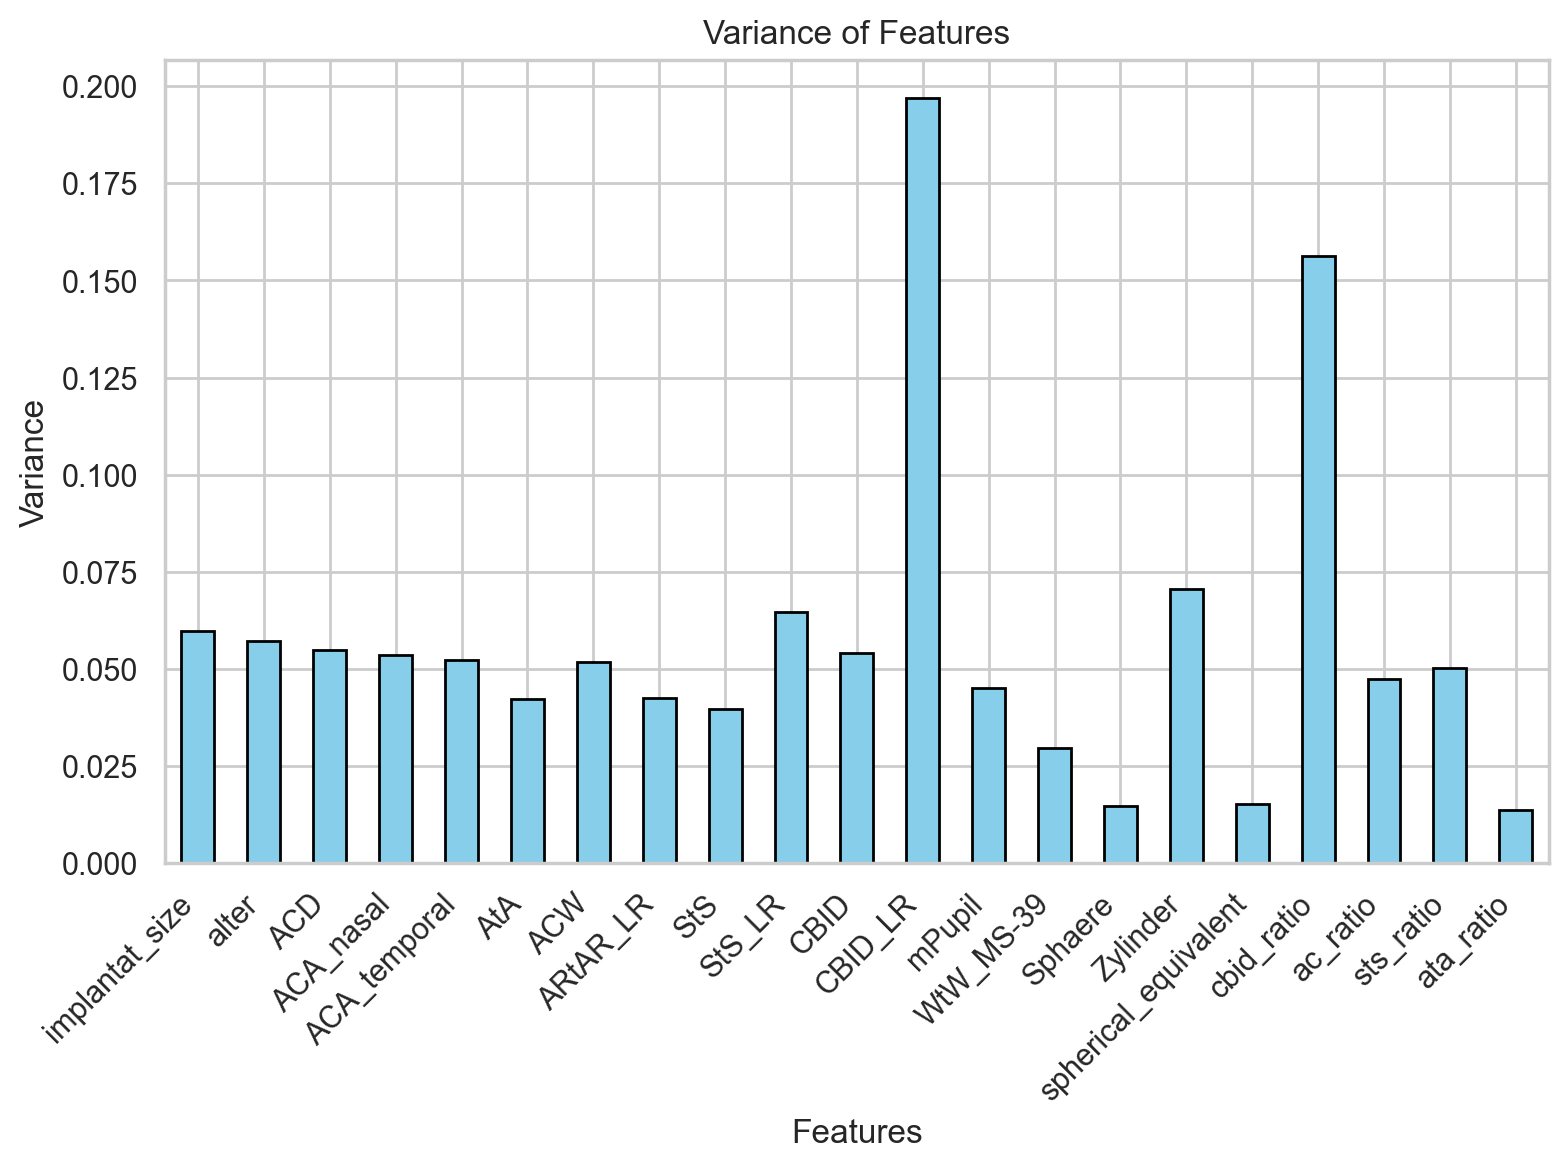

In [10]:
# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit and transform the DataFrame using the scaler
normalized_data = scaler.fit_transform(feature_df)

# Convert the normalized data back to a DataFrame
normalized_df = pd.DataFrame(normalized_data, columns=column_names[:-1])
# Calculate the variance of each feature
variance = normalized_df.var()

# Plot the variance
plt.figure(figsize=(8, 6))
variance.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Variance')
plt.title('Variance of Features')
plt.tight_layout()
plt.show()

## OLS Regression auf der vollen Featuremenge.

In [18]:
# Store column names
column_names = feature_df.columns.tolist()

# Create a StandardScaler object
scaler = StandardScaler()

# Fit and transform the DataFrame using the scaler
scaled_data = scaler.fit_transform(feature_df)

# Convert the scaled data back to a DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=column_names)

# Make sure indices are aligned
scaled_df.index = feature_df.index
target_df.index = feature_df.index

X_ols = sm.add_constant(scaled_df, has_constant='add')
est = sm.OLS(target_df, X_ols).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Lens-ICPL-Distance   R-squared:                       0.607
Model:                            OLS   Adj. R-squared:                  0.456
Method:                 Least Squares   F-statistic:                     4.012
Date:                Tue, 22 Aug 2023   Prob (F-statistic):           2.87e-05
Time:                        09:10:25   Log-Likelihood:                -453.60
No. Observations:                  73   AIC:                             949.2
Df Residuals:                      52   BIC:                             997.3
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  564.2740     16.763     33.661      0.000     530.636     597.912
implantat_size          57.5994     34.759      1.657      0.104     -12.149     127.348
alter                   40.2685     21.619      1.863      0.068      -3.113      83.650
ACD                    646.0256    252.326      2.560      0.013     139.696    1152.356
ACA_nasal              -44.9017     34.028     -1.320      0.193    -113.184      23.381
ACA_temporal           -15.7180     30.625     -0.513      0.610     -77.171      45.735
AtA                    -63.7144     44.810     -1.422      0.161    -153.631      26.203
ACW                   -254.3735    122.272     -2.080      0.042    -499.729      -9.018
ARtAR_LR               -26.3290     37.742     -0.698      0.489    -102.064      49.406
StS                    -21.5779     33.678     -0.641      0.525     -89.158      46.002
StS_LR                  -9.9843     34.951     -0.286      0.776     -80.118      60.150
CBID                   -53.2756     43.284     -1.231      0.224    -140.131      33.580
CBID_LR                255.2543    111.491      2.289      0.026      31.532     478.977
mPupil                 -11.4935     22.083     -0.520      0.605     -55.807      32.820
WtW_MS-39              -26.4830     37.968     -0.698      0.489    -102.671      49.705
Sphaere                 10.4079     10.790      0.965      0.339     -11.244      32.060
Zylinder                72.6547     20.820      3.490      0.001      30.876     114.434
spherical_equivalent     0.8491     10.075      0.084      0.933     -19.369      21.067
cbid_ratio             229.5266    106.938      2.146      0.037      14.941     444.113
ac_ratio               602.1583    255.472      2.357      0.022      89.516    1114.800
sts_ratio               -7.3220     32.282     -0.227      0.821     -72.101      57.457
ata_ratio               -2.0000     19.493     -0.103      0.919     -41.116      37.116
==============================================================================
Omnibus:                        7.425   Durbin-Watson:                   1.504
Prob(Omnibus):                  0.024   Jarque-Bera (JB):                7.213
Skew:                           0.569   Prob(JB):                       0.0271
Kurtosis:                       4.037   Cond. No.                     7.73e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.82e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Now we perform a Lasso Regression on the same feature set in order to get rid of colinearity. We use cross validation to examine the performance of our model on our target metric.

In [19]:
# Create a StandardScaler object
standard_scaler = StandardScaler()
model_lasso = Lasso()
pipeline = Pipeline([('transformer', standard_scaler), ('estimator', model_lasso)])
print(cross_val_score(pipeline, feature_df, target_df, cv=5, scoring='neg_mean_absolute_error').mean())

-162.3083157495019


/Users/sortmanns/mambaforge/envs/icl-sizing/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.057e+02, tolerance: 2.466e+02
  model = cd_fast.enet_coordinate_descent(


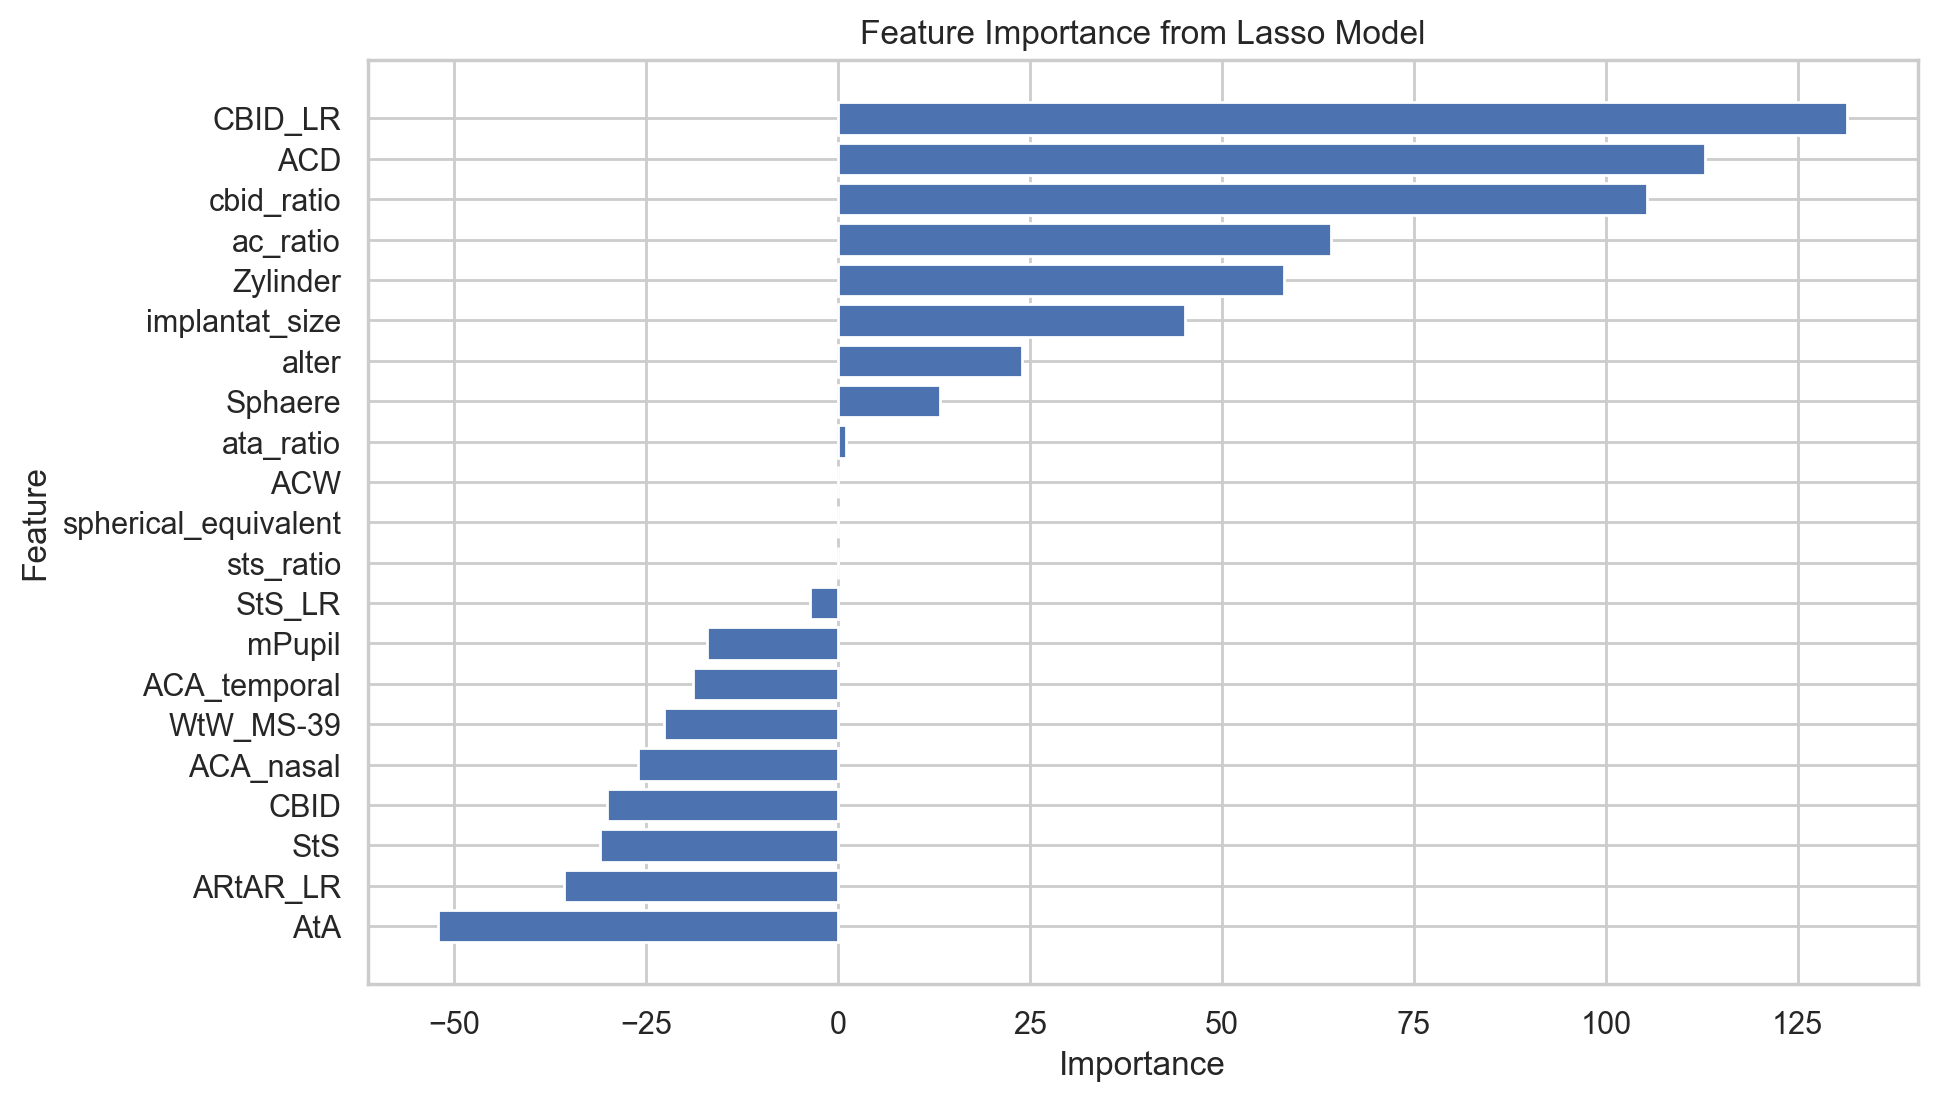

In [20]:
# Fit the pipeline on your data
pipeline.fit(feature_df, target_df)

# Get the Lasso model from the pipeline
lasso_model = pipeline.named_steps['estimator']

# Get the feature importance (coefficients) from the Lasso model
feature_importance = lasso_model.coef_

# Create a DataFrame to hold feature names and their corresponding importance values
feature_importance_df = pd.DataFrame({'Feature': feature_df.columns, 'Importance': feature_importance})

# Sort the DataFrame by importance values
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Create a bar plot for feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Lasso Model')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important features at the top
plt.show()

In [ ]:
# prepare data
features = ['ACD']
# ac_ratio = (lambda row: row['ACD'] / row['ACW'])
custom_features = None # {'ac_ratio': ac_ratio}
feature_df, target_df, feature_mapping = prepare_training_data(df=df, target="Lens-ICPL-Distance", features=features,custom_features=custom_features)
# feature_df.drop(columns=features, inplace=True)

standard_scaler = StandardScaler()
ols_features = standard_scaler.fit_transform(feature_df)

X_ols = sm.add_constant(ols_features, has_constant='add')
est = sm.OLS(target_df, X_ols).fit()


model_lasso = Lasso()
pipeline = Pipeline([('transformer', standard_scaler), ('estimator', model_lasso)])
print(cross_val_score(pipeline, feature_df, target_df, cv=5, scoring='neg_mean_absolute_error').mean())

est.summary()

In [ ]:
# prepare data
features = ['ACW']
# ac_ratio = (lambda row: row['ACD'] / row['ACW'])
custom_features = None # {'ac_ratio': ac_ratio}
feature_df, target_df, feature_mapping = prepare_training_data(df=df, target="Lens-ICPL-Distance", features=features,custom_features=custom_features)
# feature_df.drop(columns=features, inplace=True)

standard_scaler = StandardScaler()
ols_features = standard_scaler.fit_transform(feature_df)

X_ols = sm.add_constant(ols_features, has_constant='add')
est = sm.OLS(target_df, X_ols).fit()


model_lasso = Lasso()
pipeline = Pipeline([('transformer', standard_scaler), ('estimator', model_lasso)])
print(cross_val_score(pipeline, feature_df, target_df, cv=5, scoring='neg_mean_absolute_error').mean())

est.summary()

In [ ]:
# prepare data
features = ['ACW','ACD']
# ac_ratio = (lambda row: row['ACD'] / row['ACW'])
custom_features = None # {'ac_ratio': ac_ratio}
feature_df, target_df, feature_mapping = prepare_training_data(df=df, target="Lens-ICPL-Distance", features=features,custom_features=custom_features)
# feature_df.drop(columns=features, inplace=True)

standard_scaler = StandardScaler()
ols_features = standard_scaler.fit_transform(feature_df)

X_ols = sm.add_constant(ols_features, has_constant='add')
est = sm.OLS(target_df, X_ols).fit()


model_lasso = Lasso()
pipeline = Pipeline([('transformer', standard_scaler), ('estimator', model_lasso)])
print(cross_val_score(pipeline, feature_df, target_df, cv=5, scoring='neg_mean_absolute_error').mean())

est.summary()

In [ ]:
# prepare data
features = ['implantat_size','Zylinder']
# cbid_ratio = (lambda row: row['CBID'] / row['CBID_LR'])
custom_features = None # {'spherical_equivalent': (lambda row: row['Sphaere']-0.5*row['Zylinder'])}
feature_df, target_df, feature_mapping = prepare_training_data(df=df, target="Lens-ICPL-Distance", features=features,custom_features=custom_features)

standard_scaler = StandardScaler()
ols_features = standard_scaler.fit_transform(feature_df)

X_ols = sm.add_constant(ols_features, has_constant='add')
est = sm.OLS(target_df, X_ols).fit()


model_lasso = Lasso()
pipeline = Pipeline([('transformer', standard_scaler), ('estimator', model_lasso)])
print(cross_val_score(pipeline, feature_df, target_df, cv=5, scoring='neg_mean_absolute_error').mean())

est.summary()

In [ ]:
# prepare data
features = ['implantat_size','AtA','ARtAR_LR']
# cbid_ratio = (lambda row: row['CBID'] / row['CBID_LR'])
custom_features = None # {'spherical_equivalent': (lambda row: row['Sphaere']-0.5*row['Zylinder'])}
feature_df, target_df, feature_mapping = prepare_training_data(df=df, target="Lens-ICPL-Distance", features=features,custom_features=custom_features)

standard_scaler = StandardScaler()
ols_features = standard_scaler.fit_transform(feature_df)

X_ols = sm.add_constant(ols_features, has_constant='add')
est = sm.OLS(target_df, X_ols).fit()


model_lasso = Lasso()
pipeline = Pipeline([('transformer', standard_scaler), ('estimator', model_lasso)])
print(cross_val_score(pipeline, feature_df, target_df, cv=5, scoring='neg_mean_absolute_error').mean())

est.summary()

In [ ]:
# prepare data
features = ['implantat_size','AtA','ARtAR_LR',"ACD"]
# cbid_ratio = (lambda row: row['CBID'] / row['CBID_LR'])
custom_features = None # {'spherical_equivalent': (lambda row: row['Sphaere']-0.5*row['Zylinder'])}
feature_df, target_df, feature_mapping = prepare_training_data(df=df, target="Lens-ICPL-Distance", features=features,custom_features=custom_features)

standard_scaler = StandardScaler()
ols_features = standard_scaler.fit_transform(feature_df)

X_ols = sm.add_constant(ols_features, has_constant='add')
est = sm.OLS(target_df, X_ols).fit()


model_lasso = Lasso()
pipeline = Pipeline([('transformer', standard_scaler), ('estimator', model_lasso)])
print(cross_val_score(pipeline, feature_df, target_df, cv=5, scoring='neg_mean_absolute_error').mean())

est.summary()

In [ ]:
# prepare data
features = ['implantat_size','StS']
# cbid_ratio = (lambda row: row['CBID'] / row['CBID_LR'])
custom_features = None # {'spherical_equivalent': (lambda row: row['Sphaere']-0.5*row['Zylinder'])}
feature_df, target_df, feature_mapping = prepare_training_data(df=df, target="Lens-ICPL-Distance", features=features,custom_features=custom_features)

standard_scaler = StandardScaler()
ols_features = standard_scaler.fit_transform(feature_df)

X_ols = sm.add_constant(ols_features, has_constant='add')
est = sm.OLS(target_df, X_ols).fit()


model_lasso = Lasso()
pipeline = Pipeline([('transformer', standard_scaler), ('estimator', model_lasso)])
print(cross_val_score(pipeline, feature_df, target_df, cv=5, scoring='neg_mean_absolute_error').mean())

est.summary()

In [ ]:
# prepare data
features = ['implantat_size','AtA','ARtAR_LR',"ACD",'StS']
# cbid_ratio = (lambda row: row['CBID'] / row['CBID_LR'])
custom_features = None # {'spherical_equivalent': (lambda row: row['Sphaere']-0.5*row['Zylinder'])}
feature_df, target_df, feature_mapping = prepare_training_data(df=df, target="Lens-ICPL-Distance", features=features,custom_features=custom_features)

standard_scaler = StandardScaler()
ols_features = standard_scaler.fit_transform(feature_df)

X_ols = sm.add_constant(ols_features, has_constant='add')
est = sm.OLS(target_df, X_ols).fit()


model_lasso = Lasso()
pipeline = Pipeline([('transformer', standard_scaler), ('estimator', model_lasso)])
print(cross_val_score(pipeline, feature_df, target_df, cv=5, scoring='neg_mean_absolute_error').mean())

est.summary()

In [ ]:
# prepare data
features = ['implantat_size','CBID', 'CBID_LR']
# cbid_ratio = (lambda row: row['CBID'] / row['CBID_LR'])
custom_features = None # {'spherical_equivalent': (lambda row: row['Sphaere']-0.5*row['Zylinder'])}
feature_df, target_df, feature_mapping = prepare_training_data(df=df, target="Lens-ICPL-Distance",
                                                               features=features,custom_features=custom_features)

standard_scaler = StandardScaler()
ols_features = standard_scaler.fit_transform(feature_df)

X_ols = sm.add_constant(ols_features, has_constant='add')
est = sm.OLS(target_df, X_ols).fit()


model_lasso = Lasso()
pipeline = Pipeline([('transformer', standard_scaler), ('estimator', model_lasso)])
print(cross_val_score(pipeline, feature_df, target_df, cv=5, scoring='neg_mean_absolute_error').mean())

est.summary()

In [ ]:
# prepare data
features = ['implantat_size','CBID', 'CBID_LR']
cbid_ratio = (lambda row: row['CBID'] / row['CBID_LR'])
custom_features = {'cbid_ratio': cbid_ratio}
feature_df, target_df, feature_mapping = prepare_training_data(df=df, target="Lens-ICPL-Distance",
                                                               features=features,custom_features=custom_features)

standard_scaler = StandardScaler()
ols_features = standard_scaler.fit_transform(feature_df)

X_ols = sm.add_constant(ols_features, has_constant='add')
est = sm.OLS(target_df, X_ols).fit()


model_lasso = Lasso()
pipeline = Pipeline([('transformer', standard_scaler), ('estimator', model_lasso)])
print(cross_val_score(pipeline, feature_df, target_df, cv=5, scoring='neg_mean_absolute_error').mean())

est.summary()

In [ ]:
# prepare data
features = ['implantat_size','CBID_LR']
# cbid_ratio = (lambda row: row['CBID'] / row['CBID_LR'])
custom_features = None # {'spherical_equivalent': (lambda row: row['Sphaere']-0.5*row['Zylinder'])}
feature_df, target_df, feature_mapping = prepare_training_data(df=df, target="Lens-ICPL-Distance", features=features,custom_features=custom_features)

standard_scaler = StandardScaler()
ols_features = standard_scaler.fit_transform(feature_df)

X_ols = sm.add_constant(ols_features, has_constant='add')
est = sm.OLS(target_df, X_ols).fit()


model_lasso = Lasso()
pipeline = Pipeline([('transformer', standard_scaler), ('estimator', model_lasso)])
print(cross_val_score(pipeline, feature_df, target_df, cv=5, scoring='neg_mean_absolute_error').mean())

est.summary()

In [ ]:
# prepare data
features = ['implantat_size','CBID_LR', "CBID"]
cbid_ratio = (lambda row: row['CBID'] / row['CBID_LR'])
custom_features = {'cbid_ratio': cbid_ratio}
feature_df, target_df, feature_mapping = prepare_training_data(df=df, target="Lens-ICPL-Distance", features=features,custom_features=custom_features)
feature_df.drop(columns=['CBID'], inplace=True)

standard_scaler = StandardScaler()
ols_features = standard_scaler.fit_transform(feature_df)

X_ols = sm.add_constant(ols_features, has_constant='add')
est = sm.OLS(target_df, X_ols).fit()


model_lasso = Lasso()
pipeline = Pipeline([('transformer', standard_scaler), ('estimator', model_lasso)])
print(cross_val_score(pipeline, feature_df, target_df, cv=5, scoring='neg_mean_absolute_error').mean())

est.summary()

In [ ]:
# prepare data
features = ['implantat_size', 'CBID', 'CBID_LR','Sphaere', 'Zylinder']
# cbid_ratio = (lambda row: row['CBID'] / row['CBID_LR'])
custom_features = {'spherical_equivalent': (lambda row: row['Sphaere']-0.5*row['Zylinder'])}
feature_df, target_df, feature_mapping = prepare_training_data(df=df, target="Lens-ICPL-Distance", features=features,custom_features=custom_features)

standard_scaler = StandardScaler()
ols_features = standard_scaler.fit_transform(feature_df)

X_ols = sm.add_constant(ols_features, has_constant='add')
est = sm.OLS(target_df, X_ols).fit()


model_lasso = Lasso()
pipeline = Pipeline([('transformer', standard_scaler), ('estimator', model_lasso)])
print(cross_val_score(pipeline, feature_df, target_df, cv=5, scoring='neg_mean_absolute_error').mean())

est.summary()

In [ ]:
# prepare data
features = ['implantat_size', 'ACD', 'AtA', 'ACW',
            'ARtAR_LR', 'StS', 'StS_LR', 'CBID', 'CBID_LR', 'mPupil', 'WtW_MS-39', 'Sphaere', 'Zylinder']
# cbid_ratio = (lambda row: row['CBID'] / row['CBID_LR'])
custom_features = {'spherical_equivalent': (lambda row: row['Sphaere']-0.5*row['Zylinder'])}
feature_df, target_df, feature_mapping = prepare_training_data(df=df, target="Lens-ICPL-Distance", features=features,custom_features=custom_features)

standard_scaler = StandardScaler()
ols_features = standard_scaler.fit_transform(feature_df)

X_ols = sm.add_constant(ols_features, has_constant='add')
est = sm.OLS(target_df, X_ols).fit()


model_lasso = Lasso()
pipeline = Pipeline([('transformer', standard_scaler), ('estimator', model_lasso)])
print(cross_val_score(pipeline, feature_df, target_df, cv=5, scoring='neg_mean_absolute_error').mean())
print(feature_mapping)

est.summary()

In [ ]:
# prepare data
features = ['implantat_size', 'ACD', 'AtA', 'ACW',
            'ARtAR_LR', 'StS', 'StS_LR', 'CBID', 'CBID_LR', 'mPupil', 'WtW_MS-39', 'Sphaere', 'Zylinder']
cbid_ratio = (lambda row: row['CBID'] / row['CBID_LR'])
ac_ratio = (lambda row: row['ACW'] / row['ACD'])
sts_ratio = (lambda row: row['StS'] / row['StS_LR'])
ata_ratio = (lambda row: row['AtA'] / row['ARtAR_LR'])
custom_features = {'spherical_equivalent': (lambda row: row['Sphaere']-0.5*row['Zylinder']), 'cbid_ratio': cbid_ratio,
                   'ac_ratio':ac_ratio, 'sts_ratio':sts_ratio, 'ata_ratio':ata_ratio}
feature_df, target_df, feature_mapping = prepare_training_data(df=df, target="Lens-ICPL-Distance", features=features,custom_features=custom_features)
feature_df.drop(columns=['ACD', 'AtA', 'ACW', 'ARtAR_LR', 'StS', 'StS_LR', 'CBID', 'CBID_LR','Sphaere', 'Zylinder'],inplace=True)
standard_scaler = StandardScaler()
ols_features = standard_scaler.fit_transform(feature_df)

X_ols = sm.add_constant(ols_features, has_constant='add')
est = sm.OLS(target_df, X_ols).fit()


model_lasso = Lasso()
pipeline = Pipeline([('transformer', standard_scaler), ('estimator', model_lasso)])
print(cross_val_score(pipeline, feature_df, target_df, cv=5, scoring='neg_mean_absolute_error').mean())
print(feature_mapping)

est.summary()


In [ ]:
# prepare data
features = ['implantat_size', 'ACD', 'AtA', 'ACW',
            'ARtAR_LR', 'StS', 'StS_LR', 'CBID', 'CBID_LR', 'mPupil', 'WtW_MS-39', 'Sphaere', 'Zylinder']
cbid_ratio = (lambda row: row['CBID'] / row['CBID_LR'])
ac_ratio = (lambda row: row['ACW'] / row['ACD'])
sts_ratio = (lambda row: row['StS'] / row['StS_LR'])
ata_ratio = (lambda row: row['AtA'] / row['ARtAR_LR'])
custom_features = {'spherical_equivalent': (lambda row: row['Sphaere']-0.5*row['Zylinder']), 'cbid_ratio': cbid_ratio,
                   'ac_ratio':ac_ratio, 'sts_ratio':sts_ratio, 'ata_ratio':ata_ratio}
feature_df, target_df, feature_mapping = prepare_training_data(df=df, target="Lens-ICPL-Distance", features=features,custom_features=custom_features)
standard_scaler = StandardScaler()
ols_features = standard_scaler.fit_transform(feature_df)

X_ols = sm.add_constant(ols_features, has_constant='add')
est = sm.OLS(target_df, X_ols).fit()


model_lasso = Lasso()
pipeline = Pipeline([('transformer', standard_scaler), ('estimator', model_lasso)])
print(cross_val_score(pipeline, feature_df, target_df, cv=5, scoring='neg_mean_absolute_error').mean())
print(feature_mapping)

est.summary()

In [ ]:
model_lasso = Lasso()
# prepare data
from sklearn.feature_selection import RFECV, SelectKBest, f_classif
# prepare data
features = ['implantat_size', 'alter', 'ACD', 'ACA_nasal', 'ACA_temporal', 'AtA', 'ACW',
            'ARtAR_LR', 'StS', 'StS_LR', 'CBID', 'CBID_LR', 'mPupil', 'WtW_MS-39', 'Sphaere', 'Zylinder']
cbid_ratio = (lambda row: row['CBID'] / row['CBID_LR'])
ac_ratio = (lambda row: row['ACW'] / row['ACD'])
sts_ratio = (lambda row: row['StS'] / row['StS_LR'])
ata_ratio = (lambda row: row['AtA'] / row['ARtAR_LR'])
spherical_equivalent = (lambda row: row['Sphaere']-0.5*row['Zylinder'])
custom_features = {'spherical_equivalent': spherical_equivalent, 'cbid_ratio': cbid_ratio,
                   'ac_ratio':ac_ratio, 'sts_ratio':sts_ratio, 'ata_ratio':ata_ratio}
feature_df, target_df, feature_mapping = prepare_training_data(df=df, target="Lens-ICPL-Distance", features=features,custom_features=custom_features)
rfecv = RFECV(
    estimator=model_lasso,
    step=1,
    cv=5,
    scoring='neg_mean_absolute_error',
    min_features_to_select=3,
    n_jobs=2,
)
rfecv.fit(feature_df, target_df)

print(f"Optimal number of features: {rfecv.n_features_}")

In [ ]:
rfecv.get_feature_names_out()


In [ ]:
# prepare data
features = ['implantat_size', 'ACD', 'AtA', 'ACW']
# cbid_ratio = (lambda row: row['CBID'] / row['CBID_LR'])
custom_features = None # {'spherical_equivalent': (lambda row: row['Sphaere']-0.5*row['Zylinder'])}
feature_df, target_df, feature_mapping = prepare_training_data(df=df, target="Lens-ICPL-Distance", features=features,custom_features=custom_features)

standard_scaler = StandardScaler()
ols_features = standard_scaler.fit_transform(feature_df)

X_ols = sm.add_constant(ols_features, has_constant='add')
est = sm.OLS(target_df, X_ols).fit()


model_lasso = Lasso()
pipeline = Pipeline([('transformer', standard_scaler), ('estimator', model_lasso)])
print(cross_val_score(pipeline, feature_df, target_df, cv=5, scoring='neg_mean_absolute_error').mean())
print(feature_mapping)

est.summary()

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector
model_lasso = Lasso()
# prepare data
features = ['implantat_size', 'alter', 'ACD', 'ACA_nasal', 'ACA_temporal', 'AtA', 'ACW',
            'ARtAR_LR', 'StS', 'StS_LR', 'CBID', 'CBID_LR', 'mPupil', 'WtW_MS-39', 'Sphaere', 'Zylinder']
cbid_ratio = (lambda row: row['CBID'] / row['CBID_LR'])
ac_ratio = (lambda row: row['ACW'] / row['ACD'])
sts_ratio = (lambda row: row['StS'] / row['StS_LR'])
ata_ratio = (lambda row: row['AtA'] / row['ARtAR_LR'])
spherical_equivalent = (lambda row: row['Sphaere']-0.5*row['Zylinder'])
custom_features = {'spherical_equivalent': spherical_equivalent, 'cbid_ratio': cbid_ratio,
                   'ac_ratio':ac_ratio, 'sts_ratio':sts_ratio, 'ata_ratio':ata_ratio}
feature_df, target_df, feature_mapping = prepare_training_data(df=df, target="Lens-ICPL-Distance", features=features,custom_features=custom_features)

sfs = SequentialFeatureSelector(
    estimator=model_lasso,
    direction="backward",
    scoring="neg_mean_absolute_error"
)
sfs.fit(feature_df, target_df)

In [ ]:
sfs.get_feature_names_out()

In [ ]:
# prepare data
features = ['ACD', 'ACA_temporal', 'AtA', 'ACW', 'ARtAR_LR', 'CBID', 'CBID_LR',
       'Sphaere', 'Zylinder']
cbid_ratio = (lambda row: row['CBID'] / row['CBID_LR'])
custom_features = {'cbid_ratio': cbid_ratio}
feature_df, target_df, feature_mapping = prepare_training_data(df=df, target="Lens-ICPL-Distance", features=features,custom_features=custom_features)

standard_scaler = StandardScaler()
ols_features = standard_scaler.fit_transform(feature_df)

X_ols = sm.add_constant(ols_features, has_constant='add')
est = sm.OLS(target_df, X_ols).fit()


model_lasso = Lasso()
pipeline = Pipeline([('transformer', standard_scaler), ('estimator', model_lasso)])
print(cross_val_score(pipeline, feature_df, target_df, cv=5, scoring='neg_mean_absolute_error').mean())
print(feature_mapping)

est.summary()

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector
model_lasso = Lasso()
features = ['implantat_size', 'alter', 'ACD', 'ACA_nasal', 'ACA_temporal', 'AtA', 'ACW',
            'ARtAR_LR', 'StS', 'StS_LR', 'CBID', 'CBID_LR', 'mPupil', 'WtW_MS-39', 'Sphaere', 'Zylinder']
cbid_ratio = (lambda row: row['CBID'] / row['CBID_LR'])
ac_ratio = (lambda row: row['ACW'] / row['ACD'])
sts_ratio = (lambda row: row['StS'] / row['StS_LR'])
ata_ratio = (lambda row: row['AtA'] / row['ARtAR_LR'])
spherical_equivalent = (lambda row: row['Sphaere']-0.5*row['Zylinder'])
custom_features = {'spherical_equivalent': spherical_equivalent, 'cbid_ratio': cbid_ratio,
                   'ac_ratio':ac_ratio, 'sts_ratio':sts_ratio, 'ata_ratio':ata_ratio}
feature_df, target_df, feature_mapping = prepare_training_data(df=df, target="Lens-ICPL-Distance", features=features,custom_features=custom_features)

sfsf = SequentialFeatureSelector(
    estimator=model_lasso,
    direction="forward",
    scoring="neg_mean_absolute_error"
)
sfsf.fit(feature_df, target_df)

In [ ]:
sfsf.get_feature_names_out()



In [ ]:
# prepare data
features = ['implantat_size', 'ACD', 'AtA', 'ACW', 'ARtAR_LR', 'StS', 'CBID',
       'WtW_MS-39', 'Sphaere']
ac_ratio = (lambda row: row['ACW'] / row['ACD'])
custom_features = {'ac_ratio': ac_ratio}
feature_df, target_df, feature_mapping = prepare_training_data(df=df, target="Lens-ICPL-Distance", features=features,custom_features=custom_features)

standard_scaler = StandardScaler()
ols_features = standard_scaler.fit_transform(feature_df)

X_ols = sm.add_constant(ols_features, has_constant='add')
est = sm.OLS(target_df, X_ols).fit()


model_lasso = Lasso()
pipeline = Pipeline([('transformer', standard_scaler), ('estimator', model_lasso)])
print(cross_val_score(pipeline, feature_df, target_df, cv=5, scoring='neg_mean_absolute_error').mean())
print(feature_mapping)

est.summary()

In [ ]:
# prepare data
features = ['implantat_size', 'AtA', 'ACW', 'ARtAR_LR', 'StS', 'CBID',
       'WtW_MS-39', 'Sphaere']
# cbid_ratio = (lambda row: row['CBID'] / row['CBID_LR'])
custom_features = None # {'spherical_equivalent': (lambda row: row['Sphaere']-0.5*row['Zylinder'])}
feature_df, target_df, feature_mapping = prepare_training_data(df=df, target="Lens-ICPL-Distance", features=features,custom_features=custom_features)

standard_scaler = StandardScaler()
ols_features = standard_scaler.fit_transform(feature_df)

X_ols = sm.add_constant(ols_features, has_constant='add')
est = sm.OLS(target_df, X_ols).fit()


model_lasso = Lasso()
pipeline = Pipeline([('transformer', standard_scaler), ('estimator', model_lasso)])
print(cross_val_score(pipeline, feature_df, target_df, cv=5, scoring='neg_mean_absolute_error').mean())
print(feature_mapping)

est.summary()